# 🧪 05 - Evaluation of Potential New Hotspots

---

### 🎯 **Objective**

This notebook evaluates the effectiveness of **alternative hotspot definitions** based on uncertainty-aware priority criteria.

We compare the classical hotspot approach — which directly uses the predicted intensity — with new definitions that incorporate:

- 🔐 **Confidence** (based on prediction interval width)
- 🔁 **Frequency or risk intensity**, derived from different sources:
  - Historical ground truth frequency
  - Binary hotspot predictions
  - Continuous predicted crime intensity

---

We assess the impact of these definitions by analyzing their ability to **recover true crime**, using standard metrics such as:

- **PAI** (Predictive Accuracy Index)
- **PEI** (Predictive Efficiency Index)
- **PEI\*** (Normalized PEI, based on optimal coverage)

This analysis helps determine whether uncertainty-informed prioritization strategies can improve or complement existing hotspot forecasting methods.


# 📦 Environment Setup & Module Imports

We load the required Python modules and custom project utilities to evaluate hotspot prediction performance:

- `spatial_processing`: functions for grid transformations and hotspot definitions.
- `data_partition`: for splitting the dataset into train, calibration, and test periods.
- `temporal_evaluation`: for calculating spatial-temporal evaluation metrics such as PAI, PEI, and PEI\*.

We also configure the Python path to ensure all modules from the main project structure are accessible.

In [9]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))
sys.path.insert(0, project_root)

# Load modules 
from src.utils.spatial_processing import predictions_to_grid, define_hotspot_by_crimes
from src.utils.data_partition import temporal_split
from src.evaluation.temporal_evaluation import evaluate_temporal_spatial_metrics

# ⚙️ Configuration and Data Preparation

We load the project configuration file and set up parameters for evaluation:

- **Hotspot definition method**: either by fixed number of cells (`by_cells`) or by predicted crime coverage (`by_crimes`).
- **Partition settings**: specify how many months are allocated for training, calibration, and testing.

We also:

1. Load the processed real dataset from Chicago.
2. Infer the spatial grid size from maximum `row` and `col` indices.
3. Perform a temporal split of the data into train, calibration, and test periods.
4. Define the features and target variable.
5. Load the pre-trained **NaivePerCell** model for prediction.

This prepares the data pipeline for evaluating the hotspot mask performance across multiple timesteps.


In [10]:
# Load global config 
config_path = os.path.join("../../", "config.json")
with open(config_path, 'r') as f:
    config = json.load(f)

# Define hotspot method from config
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
hotspot_method = config["evaluation"].get("hotspot_definition", "by_cells")  # default

# Partition data
partition_config = config["data_partition"]
days_per_month = 30
train_days = partition_config["train_months"] * days_per_month
calibration_days = partition_config["calibration_months"] * days_per_month
test_days = partition_config["test_months"] * days_per_month

# Paths
data_dir = "../../data/real_data/Chicago/"

df=pd.read_csv(os.path.join(data_dir,"df_used.csv"))
rows, cols = tuple(df[["row","col"]].max()+1)
grid_size = (rows, cols)

df_train, df_calib, df_test = temporal_split(df, train_days, train_days + calibration_days, train_days + calibration_days + test_days)

# Define features
features = ["timestep", "row", "col"]
target = "count"

X_cal = df_calib[features].copy()
y_cal = df_calib[target].copy()

X_test = df_test[features].copy()
y_test = df_test[target].copy()

model_dir="../../results/models/real_data/Chicago/"
naive_model = joblib.load(os.path.join(model_dir,"naive_cell_model.pkl"))

# 📥 Load Priority-Based Hotspot Grids

We load the previously generated **priority classification grids** for different scenarios:

- `"Historical Frequency (Train)"`: based on how often each cell was a hotspot during the training period.
- `"Hostpot Prediction"`: the original binary hotspot prediction (baseline).
- `"Punctual Prediction"`: based on the predicted crime magnitude in each cell (normalized).

Each grid assigns a **priority category** to each cell, which will later be used to define new hotspot areas.


In [11]:
hotspots_dir="../../results/hotspots/real_data/Chicago/"
priority_grids = {}
labels = ["Historical Hotspot Frequency (Train)", "Hostpot Prediction", "Punctual Prediction"]
for name in labels:
    file_name = name.lower().replace(" ", "_") + "_priority_naive.npy"
    priority_grids[name] = {}
    priority_grids[name]["PH"]=np.load(os.path.join(hotspots_dir, file_name))


# 📊 Load Baseline Prediction and Ground Truth

We load the original **naive hotspot prediction** (used as baseline) and compute the corresponding:

- `grid_true`: actual crime counts per spatial cell and timestep (test set).
- `grid_naive`: predicted crime counts from the naive model.

These grids will be used to compute evaluation metrics and compare against the new priority-based hotspots.


In [12]:
hotspot_naive = joblib.load(os.path.join(hotspots_dir,"naive_hotspot_prediction.pkl"))
naive_pred = naive_model.predict(X_test)

# Convert to spatial grids
grid_true, grid_naive = predictions_to_grid(X_test, y_test, naive_pred, grid_size,aggregate=False)

# 🧪 Evaluate Hotspot Performance using Priority Maps

For each hotspot prioritization scenario (`Historical Frequency`, `Hotspot Prediction`, `Punctual Prediction`), we:

1. Re-define the new hotspot area by prioritizing cells **within the same crime coverage constraint**.
2. Evaluate spatial performance metrics over the test period:
   - **PAI** (Predictive Accuracy Index)
   - **PEI** (Predictive Efficiency Index)
   - **PEI\*** (Normalized PEI)

The evaluation is done per timestep, and results are aggregated for comparison.


In [13]:
for i in priority_grids:
    priority_grids[i]["NewHS"]=define_hotspot_by_crimes(grid_naive.mean(axis=0), hotspot_percentage, 
                                                        priority_grid=priority_grids[i]["PH"])
    priority_grids[i]["Metrics"]=spatial_scores=evaluate_temporal_spatial_metrics(
                                                X_test, 
                                                y_test, 
                                                naive_pred, 
                                                grid_size, 
                                                hotspot_percentage,
                                                hotspot_masks_pred=priority_grids[i]["NewHS"])
    
dfs=[]
for i in priority_grids:
    df=priority_grids[i]["Metrics"]["per_timestep"]
    df["Hotspot Type"]=i
    dfs.append(df)

df_metrics=pd.concat(dfs,axis=0)
df_metrics.groupby(["Hotspot Type"]).agg(["mean","std"]).drop("timestep",axis=1)

pai                 pei            \
                                          mean       std      mean       std   
Hotspot Type                                                                   
Historical Hotspot Frequency (Train)  2.012677  0.338352  0.517534  0.081788   
Hostpot Prediction                    2.030950  0.330213  0.522421  0.081445   
Punctual Prediction                   2.021668  0.325205  0.520505  0.084073   

                                      pei_star            
                                          mean       std  
Hotspot Type                                              
Historical Hotspot Frequency (Train)  0.577935  0.088849  
Hostpot Prediction                    0.583278  0.087352  
Punctual Prediction                   0.580924  0.088906

# 📊 Evaluate Hotspot Sensitivity across Confidence and Frequency Thresholds

We assess how changes in the **confidence threshold** and **frequency/prediction threshold** affect the quality of the resulting hotspot areas.  
This is done for three prioritization scenarios:

- **Historical Frequency (Train)**
- **Hotspot Prediction**
- **Punctual Prediction**

For each combination of thresholds:
1. A new **priority-based hotspot mask** is defined.
2. The **crime coverage constraint** is enforced.
3. Standard spatial metrics (**PAI**, **PEI**, **PEI\*** ) are evaluated per timestep.


In [14]:
hotspot_sensibility = "naive_hotspot_masks_sensitivity.pkl"
with open(os.path.join(hotspots_dir, hotspot_sensibility), "rb") as f:
    hotspot_masks_results = pickle.load(f)

for scenario in hotspot_masks_results:
    print(f"Scenario: {scenario}, # of masks: {len(hotspot_masks_results[scenario])}")

results = []

# Iterar escenarios principales
for scenario_type, scenario_data in hotspot_masks_results.items():
    # Iterar sobre cada combinación de parámetros internos
    for params_name, mask in scenario_data.items():
        
        # Extraer parámetros usando regex desde params_name
        freq_thresh_match = re.search(r"freq_([\d.]+)", params_name)
        conf_thresh_match = re.search(r"conf_([\d.]+)", params_name)

        # Verificar que exista match (algunos escenarios pueden no tener freq o conf explícitos)
        freq_thresh = float(freq_thresh_match.group(1)) if freq_thresh_match else None
        conf_thresh = float(conf_thresh_match.group(1)) if conf_thresh_match else None

        # Máscara de hotspots para evaluar
        hotspot_mask = mask

        NewHS=define_hotspot_by_crimes(grid_naive.mean(axis=0), hotspot_percentage, 
                                                        priority_grid=hotspot_mask)

        # Evaluar métricas usando la máscara generada
        eval_metrics = evaluate_temporal_spatial_metrics(
            X_test, y_test, naive_pred, grid_size, hotspot_percentage,
            hotspot_masks_pred=NewHS
        )

        # Resultados detallados por timestep
        df_timestep = eval_metrics['per_timestep'].copy()
        df_timestep["Scenario"] = scenario_type
        df_timestep["Freq Threshold"] = freq_thresh
        df_timestep["Conf Threshold"] = conf_thresh

        results.append(df_timestep)

# Consolidar todos los DataFrames
df_metrics_detailed = pd.concat(results, axis=0).reset_index(drop=True)

# df_metrics_detailed.groupby(["Scenario","Freq Threshold","Conf Threshold"]).agg({"pei_star":"mean"})


Scenario: Historical Hotspot Frequency (Train), # of masks: 100
Scenario: Hostpot Prediction, # of masks: 100
Scenario: Punctual Prediction, # of masks: 100


# 📈 Sensitivity Analysis: PEI* by Frequency and Confidence Levels

This plot summarizes the behavior of the **PEI\*** metric as a function of the **thresholds used to define hotspot frequency** (or predicted intensity) and **confidence level**.

- The x-axis represents the **threshold for hotspot selection**, either from historical frequency or prediction magnitude.
- The lines represent different **scenario types**: historical frequency, hotspot prediction, or punctual prediction.
- The line **style** encodes the **confidence threshold** used to define high/low certainty cells:
  - **High** (0.7–1.0)
  - **Medium** (0.3–0.7)
  - **Low** (0.0–0.3)

This visualization helps identify:
- Which strategies yield the **highest predictive efficiency**.
- How performance varies with different levels of **model certainty**.


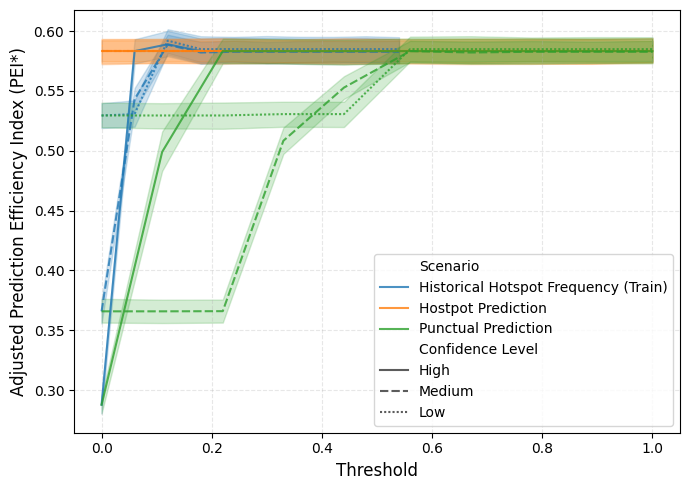

In [19]:
df_metrics_detailed["Confidence Level"] = pd.cut(
    df_metrics_detailed["Conf Threshold"],
    bins=[0, 0.3, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

plt.figure(figsize=(7, 5))

sns.lineplot(
    data=df_metrics_detailed,
    x="Freq Threshold",
    y="pei_star",
    hue="Scenario",
    style="Confidence Level",
    palette="tab10",
    alpha=0.8,
    style_order=["High","Medium","Low"]
)

# plt.title("PEI* Sensitivity Analysis by Crime and Confidence Levels", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Adjusted Prediction Efficiency Index (PEI*)", fontsize=12)
plt.legend(title="", loc='lower right', fontsize=10)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("../../results/figures/sensitivity.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()